## 1. Configuración


In [112]:
%pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu
Note: you may need to restart the kernel to use updated packages.


In [113]:
%pip install scikit-learn wandb


Note: you may need to restart the kernel to use updated packages.


In [114]:
%pip install torchview torchviz graphviz


Note: you may need to restart the kernel to use updated packages.


## Librerías

In [115]:
import torch
import torch.utils.data
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR, CosineAnnealingLR

import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torchview import draw_graph
from torchviz import make_dot

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import wandb

import ssl
import os
from tqdm import tqdm
import json


In [116]:
# El backend para correr con la GPU de los procesadores M1 de Apple es Metal, por lo que setiamos el device a MPS
# Para correr con la GPU T4 de Google Colab, o con la 1080 TI de la PC, setiamos el device a CUDA

device = torch.device(
    'mps:0' if torch.backends.mps.is_available() else 'cuda:0' if torch.cuda.is_available() else 'cpu'
    )

device


device(type='mps', index=0)

In [117]:
wandb.login()


True

In [118]:
# En algunas redes wifi no contabamos con HTTPS para descargar el dataset
ssl._create_default_https_context = ssl._create_unverified_context


In [119]:
# Chequeamos si la carpeta data existe, si no existe la creamos
download = not os.path.isdir('./data')


In [120]:
torch.manual_seed(181988)

if torch.cuda.is_available():
    torch.cuda.manual_seed(181988)


In [160]:
batch_size = 10

# Para modelos simples
end_transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

# Para modelos con mayor tamaño de entrada
transform_224 = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
        


### Train Set y Validation Set


In [161]:
# Descargamos el dataset CIFAR10 y lo guardamos en la variable train_set
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=download, transform=end_transform
)

# Guardamos en targets_ las etiquetas de las imágenes del dataset
targets_ = train_set.targets

# Dividimos el dataset en train y validation
train_idx, val_idx = train_test_split(
    np.arange(len(targets_)), test_size=0.2, stratify=targets_
)

# Creamos los samplers para train y validation
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

# Creamos los dataloaders para train y validation
train_loader = torch.utils.data.DataLoader(
    train_set, sampler=train_sampler, batch_size=batch_size, num_workers=2
)
val_loader = torch.utils.data.DataLoader(
    train_set, sampler=val_sampler, batch_size=batch_size, num_workers=2
)


### Test Set


In [162]:
# Descargamos el dataset CIFAR10 y lo guardamos en la variable test_set
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=download, transform=end_transform
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


In [124]:
def set_transforms(transform):
    """
    Setea la transformación de los datasets de train, test y validation
    """
    global train_loader
    global test_loader
    global val_loader

    train_loader.dataset.transform = transform
    test_loader.dataset.transform = transform
    val_loader.dataset.transform = transform

def get_transforms():
    """
        Devuelve la transformación de los datasets de train, test y validation
    """
    return train_loader.dataset.transform


### Visualizacion


In [176]:
def visualize_model(model):
    """
        Visualiza el modelo y lo guarda en la carpeta plots
    """

    global test_loader, device

    try:

        model_arch = model.__class__.__name__
        print(f"Visualizing {model_arch} model")

        if model_arch in ["VGG16", "VGG19", "ResNet", "InceptionNet_V1"]:
            set_transforms(transform_224)
            dataiter = iter(test_loader)
            data = next(dataiter)
            test_images, _ = data[0].to(device), data[1].to(device)

            # if model_arch == "InceptionNet_V1":
                # x = torch.squeeze(test_images[0:10], 0)
            # else:
            x = test_images[0]
            x = x.unsqueeze(0)

            print(f"Input shape: {x.shape}")
            x = x.to(device)
        else:
            x = torch.randn(1, 3, 32, 32).to(device)

        y = model(x)

        make_dot(y, params=dict(model.named_parameters())).render(f"plots/{model_arch}/dot.gv", view=True)

        nn_graph = draw_graph(model, x, expand_nested=True)
        nn_graph.visual_graph.render(f"plots/{model_arch}/graph.gv", view=True)
        return nn_graph.visual_graph
    except Exception as e:
        print(e)
        print(f"Error visualizing {model_arch} model")        


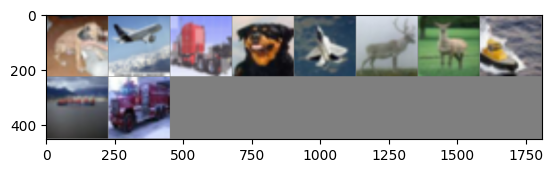

dog   plane truck dog   plane deer  deer  ship  ship  truck


torch.Size([3, 224, 224])

In [177]:
%matplotlib inline
# Funcion para mostrar imagenes
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Tomar imagenes random
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Mostramos imagenes
grid = torchvision.utils.make_grid(images)
imshow(grid)

# Printeamos las etiquetas de las imagenes
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

image_size = images[0].shape
image_size


## 2. Arquitectura


### Neural Network


In [127]:
class BaseNet(nn.Module):
    """
        Clase Red Neuronal base
    """
    def _init_(self):
        super()._init_()
        self.fc1 = nn.Linear(32 * 32 * 3, 32 * 32 * 3)
        self.fc21 = nn.Linear(32 * 32 * 3, 32 * 32)
        self.fc22 = nn.Linear(32 * 32, 120)
        self.fc23 = nn.Linear(120, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc21(x))
        x = F.relu(self.fc22(x))
        x = F.relu(self.fc23(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


#### Softmax Dropout Relu

In [128]:
class Net1(nn.Module):
    """
        Clase Red Neuronal 1: Softmax Dropout ReLU
    """
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(32 * 32 * 3, 32 * 32 * 3)
        self.fc21 = nn.Linear(32 * 32 * 3, 32 * 32)
        self.d1 = nn.Dropout(0.2)
        self.fc22 = nn.Linear(32 * 32, 800)
        self.d2 = nn.Dropout(0.2)
        self.fc23 = nn.Linear(800, 360)
        self.fc24 = nn.Linear(360, 480)
        self.fc25 = nn.Linear(480, 240)
        self.fc26 = nn.Linear(240, 120)
        self.d3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(120, 90)
        self.fc3 = nn.Linear(90, 24)
        self.fc4 = nn.Linear(24, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc21(x))
        x = self.d1(x)
        x = F.leaky_relu(self.fc22(x))
        x = self.d2(x)
        x = F.leaky_relu(self.fc23(x))
        x = F.leaky_relu(self.fc24(x))
        x = F.leaky_relu(self.fc25(x))
        x = F.leaky_relu(self.fc26(x))
        x = self.d3(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        return x

net = Net1().to(device)

set_transforms(end_transform)


In [129]:
visualize_model(Net1().to(device))


Visualizing Net1 model


In [130]:
Net1().to(device)


Net1(
  (fc1): Linear(in_features=3072, out_features=3072, bias=True)
  (fc21): Linear(in_features=3072, out_features=1024, bias=True)
  (d1): Dropout(p=0.2, inplace=False)
  (fc22): Linear(in_features=1024, out_features=800, bias=True)
  (d2): Dropout(p=0.2, inplace=False)
  (fc23): Linear(in_features=800, out_features=360, bias=True)
  (fc24): Linear(in_features=360, out_features=480, bias=True)
  (fc25): Linear(in_features=480, out_features=240, bias=True)
  (fc26): Linear(in_features=240, out_features=120, bias=True)
  (d3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=120, out_features=90, bias=True)
  (fc3): Linear(in_features=90, out_features=24, bias=True)
  (fc4): Linear(in_features=24, out_features=10, bias=True)
)

#### LeakyRelu Dropout


In [131]:
class Net2(nn.Module):
    """
        Clase Red Neuronal 2: Dropout LeakyReLU
    """
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(32 * 32 * 3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.d1 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 256)
        self.d2 = nn.Dropout(0.4)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.d3 = nn.Dropout(0.4)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 16)
        self.d4 = nn.Dropout(0.4)
        self.fc9 = nn.Linear(16, 16)
        self.fc10 = nn.Linear(16, 10)
        self.d5 = nn.Dropout(0.4)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.d1(x)
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        x = self.d2(x)
        x = F.leaky_relu(self.fc5(x))
        x = F.leaky_relu(self.fc6(x))
        x = self.d3(x)
        x = F.leaky_relu(self.fc7(x))
        x = F.leaky_relu(self.fc8(x))
        x = self.d4(x)
        x = F.leaky_relu(self.fc9(x))
        x = F.leaky_relu(self.fc10(x))
        x = self.d5(x)
        x = F.log_softmax(x, dim=1)
        return x

net = Net2().to(device)

set_transforms(end_transform)


In [132]:
visualize_model(Net2().to(device))


Visualizing Net2 model


#### Relu ELU LeakyRelu


In [133]:
class Net3(nn.Module):
    """
        Clase Red Neuronal 3: Relu ELU LeakyRelu
    """
    
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.d1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.d2 = nn.Dropout(0.3)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 10)
        self.d3 = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.d1(x)
        x = F.elu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))  
        x = self.fc4(x)
        x = self.d2(x)
        x = F.elu(self.fc5(x))
        x = F.leaky_relu(self.fc6(x))
        x = F.leaky_relu(self.fc7(x))
        x = self.d3(x)
        x = F.log_softmax(x, dim=1)
        return x

net = Net3().to(device)

set_transforms(end_transform)


In [134]:
visualize_model(Net3().to(device))


Visualizing Net3 model


## 3. Arquitecturas CNNs

In [135]:
class BaseConv(nn.Module):
    """
        Clase Red Neuronal Convolucional base
    """
    def _init_(self):
        super()._init_()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc21 = nn.Linear(120, 120)
        self.fc22 = nn.Linear(120, 120)
        self.fc23 = nn.Linear(120, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc21(x))
        x = F.relu(self.fc22(x))
        x = F.relu(self.fc23(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


### NetConv


In [136]:
class NetConv(nn.Module):

    """
        Clase Red Neuronal Convolucional 1: LeakyReLU
    """

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc21 = nn.Linear(120, 120)
        self.fc22 = nn.Linear(120, 120)
        self.fc23 = nn.Linear(120, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc21(x))
        x = F.leaky_relu(self.fc22(x))
        x = F.leaky_relu(self.fc23(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = NetConv().to(device)

set_transforms(end_transform)


In [137]:
visualize_model(NetConv().to(device))


Visualizing NetConv model


### VGG


#### VGG16

Implementación de VGG16 en PyTorch
https://blog.paperspace.com/vgg-from-scratch-pytorch/#vgg16-from-scratch


In [138]:
class VGG16(nn.Module):
    
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.layer13(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

net = VGG16().to(device)

set_transforms(transform_224)


In [139]:
visualize_model(VGG16().to(device))


Visualizing VGG16 model
Input shape: torch.Size([1, 3, 224, 224])


#### VGG19

Implementación en Keras de VGG19 de la que basamos nuestra implementación reescribiendola en PyTorch https://github.com/fchollet/deep-learning-models/blob/master/vgg19.py


In [140]:
class VGG19(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG19, self).__init__()
        
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(), 
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ]
        )
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True))
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True))
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer9 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        self.layer14 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        self.layer15 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True))
        self.layer16 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout())
        self.fc1 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout())
        self.fc2 = nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.layer13(x)
        x = self.layer14(x)
        x = self.layer15(x)
        x = self.layer16(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
net = VGG19().to(device)

set_transforms(net.transform)

net


VGG19(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_siz

In [141]:
visualize_model(VGG19().to(device))


Visualizing VGG19 model
Input shape: torch.Size([1, 3, 224, 224])


### InceptionNet

Implementación de InceptionNet en PyTorch
https://www.kaggle.com/code/mohamedmustafa/10-implement-inceptionnet-from-scratch-pytorch


In [142]:
class ConvBlock(nn.Module):
    def __init__(self, In_Channels, Out_Channels, Kernel_Size, Stride, Padding):
        super(ConvBlock, self).__init__()
        self.Conv = nn.Conv2d(in_channels=In_Channels, out_channels=Out_Channels, kernel_size=Kernel_Size, stride=Stride, padding=Padding)
        self.Batch_Norm = nn.BatchNorm2d(num_features=Out_Channels)
        self.Activ_Func = nn.ReLU()
    
    """
    Ahora construiremos la función forward que define el camino hacia el tensor de entrada dandole a entender al tensor la secuencia de capas que se está atravesando
    """
    
    def forward(self, Tensor_Path):
        Tensor_Path = self.Conv(Tensor_Path)
        Tensor_Path = self.Batch_Norm(Tensor_Path)
        Tensor_Path = self.Activ_Func(Tensor_Path)
        
        return Tensor_Path


In [143]:
class InceptionBlock(nn.Module):
    def __init__(self,In_Channels, Num_Of_Filters_1x1, Num_Of_Filters_3x3, Num_Of_Filters_5x5, Num_Of_Filters_3x3_Reduce,Num_Of_Filters_5x5_Reduce, Pooling):
        super(InceptionBlock, self).__init__()
        # The In_Channels are the depth of tensor coming from previous layer
        # First block contains only filters with kernel size 1x1
        self.Block_1 = nn.Sequential(ConvBlock(In_Channels=In_Channels, Out_Channels=Num_Of_Filters_1x1, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0)))
        
        # Second Block contains filters with kernel size 1x1 followed by 3x3
        self.Block_2 = nn.Sequential(
            ConvBlock(In_Channels=In_Channels, Out_Channels= Num_Of_Filters_3x3_Reduce, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0)),
            ConvBlock(In_Channels=Num_Of_Filters_3x3_Reduce, Out_Channels= Num_Of_Filters_3x3, Kernel_Size=(3,3), Stride=(1,1), Padding=(1,1))
        )
        
        # Third Block same as second block unless we'll replace the 3x3 filter with 5x5 
        self.Block_3 = nn.Sequential(
            ConvBlock(In_Channels=In_Channels, Out_Channels= Num_Of_Filters_5x5_Reduce, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0)),
            ConvBlock(In_Channels=Num_Of_Filters_5x5_Reduce, Out_Channels= Num_Of_Filters_5x5, Kernel_Size=(5,5), Stride=(1,1), Padding=(2,2))
        )
        
        # Fourth Block contains maxpooling layer followed by 1x1 filter
        self.Block_4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            ConvBlock(In_Channels=In_Channels, Out_Channels=Pooling, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0))
        )
    def forward(self, Tensor_Path):
        First_Block_Out = self.Block_1(Tensor_Path)
        Second_Block_Out = self.Block_2(Tensor_Path)
        Third_Block_Out = self.Block_3(Tensor_Path)
        Fourth_Block_Out = self.Block_4(Tensor_Path)
        
        Concatenated_Outputs = torch.cat([First_Block_Out,Second_Block_Out, Third_Block_Out, Fourth_Block_Out], dim=1) #dim=1 because we want to concatenate in the depth dimension
        return Concatenated_Outputs


In [144]:
class Auxiliary_Classifier(nn.Module):
    def __init__(self, In_Channels, Num_Classes):
        super(Auxiliary_Classifier, self).__init__()
        self.Adaptive_AvgPool = nn.AdaptiveAvgPool2d(output_size=(4, 4))
        self.Conv = nn.Conv2d(in_channels= In_Channels, out_channels=128, kernel_size=(1,1), stride=(1,1), padding=(0,0))
        self.Activ_Func = nn.ReLU()
        # in_features=2048 because we should flatten the input tensor which has shape of (batch, 4,4,128) so after flaten the tensor will be (batch, 4*4*128)
        # out_features=1024 this number from paper
        self.FC_1 = nn.Linear(in_features=2048, out_features=1024) 
        self.DropOut = nn.Dropout(p=0.7) 
        self.FC_2 = nn.Linear(in_features=1024, out_features= Num_Classes)
    
    def forward(self, Tensor_Path):
        Tensor_Path = self.Adaptive_AvgPool(Tensor_Path)
        Tensor_Path = self.Conv(Tensor_Path)
        Tensor_Path = self.Activ_Func(Tensor_Path)
        Tensor_Path = torch.flatten(Tensor_Path, 1)
        Tensor_Path = self.FC_1(Tensor_Path)
        Tensor_Path = self.DropOut(Tensor_Path)
        Tensor_Path = self.FC_2(Tensor_Path)
        
        return Tensor_Path


In [145]:
class InceptionNet_V1(nn.Module):
    def __init__(self, Out_Classes):
        super(InceptionNet_V1, self).__init__()
        self.Conv_1 = ConvBlock(In_Channels=3, Out_Channels=64, Kernel_Size=(7,7), Stride=(2,2), Padding=(3,3))
        self.MaxPool_1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(0,0), ceil_mode=True)
        self.Conv_2 = ConvBlock(In_Channels=64, Out_Channels=64, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0))
        self.Conv_3 = ConvBlock(In_Channels=64, Out_Channels=192, Kernel_Size=(3,3), Stride=(1,1), Padding=(1,1))
        self.MaxPool_2 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(0,0), ceil_mode=True)
        self.Inception_3a = InceptionBlock(In_Channels=192, Num_Of_Filters_1x1=64, Num_Of_Filters_3x3=128
                                          , Num_Of_Filters_5x5=32, Num_Of_Filters_3x3_Reduce=96, 
                                           Num_Of_Filters_5x5_Reduce=16, Pooling=32)
        
        self.Inception_3b = InceptionBlock(In_Channels=256, Num_Of_Filters_1x1=128, Num_Of_Filters_3x3=192
                                          , Num_Of_Filters_5x5=96, Num_Of_Filters_3x3_Reduce=128, 
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=64)
        
        self.MaxPool_3 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(0,0), ceil_mode=True)
        self.Inception_4a = InceptionBlock(In_Channels=480, Num_Of_Filters_1x1=192, Num_Of_Filters_3x3=208
                                          , Num_Of_Filters_5x5=48, Num_Of_Filters_3x3_Reduce=96, 
                                           Num_Of_Filters_5x5_Reduce=16, Pooling=64)
        
        self.Inception_4b = InceptionBlock(In_Channels=512, Num_Of_Filters_1x1=160, Num_Of_Filters_3x3=224
                                          , Num_Of_Filters_5x5=64, Num_Of_Filters_3x3_Reduce=112, 
                                           Num_Of_Filters_5x5_Reduce=24, Pooling=64)
        
        
        self.Inception_4c = InceptionBlock(In_Channels=512, Num_Of_Filters_1x1=128, Num_Of_Filters_3x3=256
                                          , Num_Of_Filters_5x5=64, Num_Of_Filters_3x3_Reduce=128, 
                                           Num_Of_Filters_5x5_Reduce=24, Pooling=64)
        
       
        self.Inception_4d = InceptionBlock(In_Channels=512, Num_Of_Filters_1x1=112, Num_Of_Filters_3x3=288
                                          , Num_Of_Filters_5x5=64, Num_Of_Filters_3x3_Reduce=144, 
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=64) 
        
        self.Inception_4e = InceptionBlock(In_Channels=528, Num_Of_Filters_1x1=256, Num_Of_Filters_3x3=320
                                          , Num_Of_Filters_5x5=128, Num_Of_Filters_3x3_Reduce=160, 
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=128) 
        
        self.MaxPool_4 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(0,0), ceil_mode=True)
        self.Inception_5a = InceptionBlock(In_Channels=832, Num_Of_Filters_1x1=256, Num_Of_Filters_3x3=320
                                          , Num_Of_Filters_5x5=128, Num_Of_Filters_3x3_Reduce=160, 
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=128) 
        
        self.Inception_5b = InceptionBlock(In_Channels=832, Num_Of_Filters_1x1=384, Num_Of_Filters_3x3=384
                                          , Num_Of_Filters_5x5=128, Num_Of_Filters_3x3_Reduce=192, 
                                           Num_Of_Filters_5x5_Reduce=48, Pooling=128) 
        
        self.AvgPool_1 = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.DropOut = nn.Dropout(p=0.4)
        self.FC = nn.Linear(in_features=1024, out_features=Out_Classes)
        
        self.Auxiliary_4a = Auxiliary_Classifier(In_Channels=512, Num_Classes=Out_Classes)
        self.Auxiliary_4d = Auxiliary_Classifier(In_Channels=528, Num_Classes=Out_Classes)
        
    def forward(self, Tensor_Path):
        Tensor_Path = self.Conv_1(Tensor_Path)
        Tensor_Path = self.MaxPool_1(Tensor_Path)
        Tensor_Path = self.Conv_2(Tensor_Path)
        Tensor_Path = self.Conv_3(Tensor_Path)
        Tensor_Path = self.MaxPool_2(Tensor_Path)
        Tensor_Path = self.Inception_3a(Tensor_Path)
        Tensor_Path = self.Inception_3b(Tensor_Path)
        Tensor_Path = self.MaxPool_3(Tensor_Path)
        Tensor_Path = self.Inception_4a(Tensor_Path)
        Auxiliary_1 = self.Auxiliary_4a(Tensor_Path)
        Tensor_Path = self.Inception_4b(Tensor_Path)
        Tensor_Path = self.Inception_4c(Tensor_Path)
        Tensor_Path = self.Inception_4d(Tensor_Path)
        Auxiliary_2 = self.Auxiliary_4d(Tensor_Path)
        Tensor_Path = self.Inception_4e(Tensor_Path)
        Tensor_Path = self.MaxPool_4(Tensor_Path)
        Tensor_Path = self.Inception_5a(Tensor_Path)
        Tensor_Path = self.Inception_5b(Tensor_Path)
        Tensor_Path = self.AvgPool_1(Tensor_Path)
        Tensor_Path = torch.flatten(Tensor_Path, 1)
        Tensor_Path = self.DropOut(Tensor_Path)
        Tensor_Path = self.FC(Tensor_Path)
        
        return Tensor_Path, Auxiliary_1, Auxiliary_2

# InceptionNet_V1 Necesita AdaptiveAVGPool con input dim no divisibles por output dim, pero no se encuentra implementado para MPS, se puede corrar con CUDA o CPU

#if device == 'MPS':
#    raise Exception('InceptionNet_V1 Necesita AdaptiveAVGPool con input dim no divisibles por output dim, pero no se encuentra implementado para MPS, se puede corrar con CUDA o CPU')

net = InceptionNet_V1(10).to(device)

set_transforms(transform_224)


In [146]:
if device == 'MPS':
    model = InceptionNet_V1(10).to("cpu")

    set_transforms(transform_224)
    dataiter = iter(test_loader)
    data = next(dataiter)
    test_images, test_labels = data[0].to("cpu"), data[1].to("cpu")

    x = test_images[0]
    x = x.to("cpu")
    x = x.unsqueeze(0)

    print(f"Input shape: {x.shape}")

    y, aux1, aux2 = model(x)

    make_dot(y, params=dict(model.named_parameters())).render(f"plots/InceptionNet_V1/dot.gv", view=True)

    nn_graph = draw_graph(model, x, expand_nested=True)

    nn_graph.visual_graph.render(f"plots/InceptionNet_V1/graph.gv", view=True)


### ResNet 
https://arxiv.org/abs/1512.03385

Implementación de ResNet en PyTorch https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/


In [147]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


In [163]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

net = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)


In [149]:
visualize_model(ResNet(ResidualBlock, [2, 2, 2, 2]).to(device))


Visualizing ResNet model
Input shape: torch.Size([1, 3, 224, 224])


## 4. Data Augmentation


In [164]:
get_transforms()


Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [151]:
aug_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.RandomPerspective(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    ]
)


In [152]:
# Agregar transformaciones de data augmentation antes de las transformaciones finales

cur_transform = get_transforms()
if cur_transform.transforms[0].__class__.__name__ != 'Compose':
    cur_transform.transforms.insert(0, aug_transform)
    set_transforms(cur_transform)

get_transforms()


Compose(
    Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    RandomPerspective(p=0.5)
    ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.5, 0.5))
)
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

## 5. Optimizadores

Realizar experimentos evaluando distintos optimizadores, schedulers y reportar el mejor y peor experimento. ¿Qué estrategia utilizaron? ¿Qué resultados obtuvieron?


In [165]:
net = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
set_transforms(transform_224)

## Parámetros de entrenamiento
learning_rate = 0.05
momentum = 0.5
epochs = 10

weight_decay = 0.0005

step_size = 4
gamma = 0.7


In [166]:
# Optimizador y función de pérdida
criterion = nn.CrossEntropyLoss()

optimizers = {
    "SGD": optim.SGD(
            net.parameters(),
            lr=learning_rate,
            momentum=momentum,
            #weight_decay=weight_decay
        ),
    "RMSprop": optim.RMSprop(
        net.parameters(),
        lr=learning_rate,
        momentum=momentum,
        weight_decay=weight_decay
    ),
    "Adam": optim.Adam(
        net.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )
}

optimizer = optimizers["SGD"]

schedulers = {
    "StepLR": StepLR(
        optimizer,
        step_size=step_size,
        gamma=gamma
    ),
    "MultiStepLR": MultiStepLR(
        optimizer,
        milestones=[4, 8, 12],
        gamma=gamma
    ),
    "CosineAnnealingLR": CosineAnnealingLR(
        optimizer,
        T_max = 32,
        eta_min = learning_rate,
    )
}


scheduler = None


## 6. Entrenamiento

Realizar experimentos evaluando distintos batch-sizes, epochs y reportar el mejor y peor experimento. ¿Qué resultados obtuvieron?


### Configuración Wandb


In [167]:
# Nombre del experimento
project_name = "TP3"
experiment_name = f"{net.__class__.__name__ } optimizer={optimizer.__class__.__name__} lr={learning_rate} momentum={momentum} epochs={epochs} device={device}"

if scheduler:
    experiment_name += f" scheduler={scheduler.__class__.__name__}"

experiment_name


'ResNet optimizer=SGD lr=0.05 momentum=0.5 epochs=10 device=mps:0'

In [168]:
wandb.finish()
wandb.init(
    # seteamos el projecto donde se va a guardar el experimento en wandb
    project=project_name,
    name=experiment_name,
    
    # trackeamos los hiperparámetros y las métricas
    config={
        "learning_rate": learning_rate,
        "momentum": momentum,
        "batch_size": batch_size,
        "epochs": epochs,
    },
)


### Entrenamiento


#### Funciones de entranamiento


In [169]:
def train_InceptionV1(model, train_loader, val_loader, num_of_train_samples, num_of_val_samples, criterion, optimizer, epochs, log, scheduler=None):
    iterator = tqdm(
        range(epochs),
        total=epochs,
        desc="Epoch"
    )

    # --------------------------------- TRAIN SET -----------------------------#
    
    # La accuracy y la loss de train y validation se guardan en estas listas por epoch
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []

    train_accuracy = 0
    val_accuracy = 0
    train_cummulative_loss = 0
    val_cummulative_loss = 0
    
    for epoch in iterator:

        num_of_predicted_correctly = 0 # numero de predicciones correctas
        train_cummulative_loss = 0 # suma de las loss de cada batch
        
        for i, data in enumerate(train_loader):
            batch_samples, targets = data
            batch_samples = batch_samples.to(device=device)
            targets = targets.to(device=device)
            
            # pasa las muestras de train por la red (Forward Path)
            network_predictions, aux_1_predictions, aux_2_predictions = model(batch_samples)
            
            # Network Loss contiene la loss promedio de cada batch
            network_loss = criterion(network_predictions, targets)
            aux_1_loss = criterion(aux_1_predictions, targets)
            aux_2_loss = criterion(aux_2_predictions, targets)
            
            # Pondera las losses de cada bloque de la red como dice el paper
            main_loss = network_loss + (0.3 * aux_1_loss) + (0.3 * aux_2_loss)
            
            # Backward Propagation
            optimizer.zero_grad() # gradientes a cero
            main_loss.backward() # backpropagation
            optimizer.step() # actualizacion de pesos
            if scheduler:
                scheduler.step()
            
            _, train_samples_predictions = network_predictions.max(1)
            train_samples_predictions = train_samples_predictions.to(device=device)
            num_of_predicted_correctly += (train_samples_predictions == targets).float().sum().item()
            train_cummulative_loss += main_loss.data.item() * batch_samples.shape[0]
            
            iterator.set_postfix(
                {
                    "train_accuracy": train_accuracy,
                    "val_accuracy": val_accuracy,
                    "train_loss": train_cummulative_loss,
                    "val_loss": val_cummulative_loss,
                    "train iter": i,
                }
            )

        train_cummulative_loss /= num_of_train_samples
        train_loss_history.append(train_cummulative_loss)
        train_accuracy = 100 * num_of_predicted_correctly / num_of_train_samples
        train_accuracy_history.append(train_accuracy)


    
    #----------------------------- VALIDATION SET -----------------------------#
    
        num_of_predicted_correctly = 0
        with torch.no_grad(): # Como estamos en validacion no necesitamos calcular los gradientes
            val_cummulative_loss = 0
            for batch_samples,targets in val_loader:
                batch_samples = batch_samples.to(device=device)
                targets = targets.to(device=device)

                # psamos los samples de validacion por la red (Forward Path)
                network_predictions, aux_1_predictions, aux_2_predictions = model(batch_samples)

                # Network loss guarda la loss promedio de cada batch
                network_loss = criterion(network_predictions, targets)
                aux_1_loss = criterion(aux_1_predictions, targets)
                aux_2_loss = criterion(aux_2_predictions, targets)

                # Pondera las losses de cada bloque de la red como dice el paper
                main_loss = network_loss + (0.3 * aux_1_loss) + (0.3 * aux_2_loss)

                _, val_samples_predictions = network_predictions.max(1)
                val_samples_predictions = val_samples_predictions.to(device=device)
                num_of_predicted_correctly += (val_samples_predictions == targets).float().sum().item()
                val_cummulative_loss += main_loss.data.item() * batch_samples.shape[0]
            
            val_cummulative_loss /= num_of_val_samples
            val_loss_history.append(val_cummulative_loss)
            val_accuracy = 100 * num_of_predicted_correctly / num_of_val_samples
            val_accuracy_history.append(val_accuracy)

            if log:   
                wandb.log(
                    {
                        "train_accuracy": train_accuracy,
                        "val_accuracy": val_accuracy,
                        "train_loss": train_cummulative_loss,
                        "val_loss": val_cummulative_loss,
                    }
                )

            iterator.set_postfix(
                {
                    "train_accuracy": train_accuracy,
                    "val_accuracy": val_accuracy,
                    "train_loss": train_cummulative_loss,
                    "val_loss": val_cummulative_loss,
                }
            )
        
    torch.save(model.state_dict(), "InceptionNet_Model")
    return train_accuracy, val_accuracy, train_cummulative_loss, val_cummulative_loss

def propagate_InceptionNetwork(model, optimizer, criterion, epochs, log, scheduler=None):
    if type(model) == InceptionNet_V1:    
        return train_InceptionV1(
            model = model, 
            train_loader = train_loader,
            val_loader = val_loader,
            num_of_train_samples = 40000,
            num_of_val_samples = 10000,
            criterion = criterion,
            optimizer = optimizer,
            epochs = epochs,
            log = log, 
            scheduler = scheduler
        )
    else:
        raise Exception("Modelo no es InceptionNetV1")
    
def propagate_network(net, optimizer, criterion, epochs, log, scheduler=None):
    iterator = tqdm(
        range(epochs),
        total=epochs,
        desc="Epoch"
    )

    train_accuracy = 0
    val_accuracy = 0
    running_loss = 0
    val_loss = 0   
    
    for epoch in iterator:
        
        # ---------------- SECCION DE TRAIN -----------------

        running_loss = 0.0
        train_correct = 0
        total = 0

        for i, data in enumerate(train_loader, 0):

            # Los datos son una lista de [inputs, labels]
            # inputs, labels = data
            inputs, labels = data[0].to(device), data[1].to(device)

            # Reiniciamos gradientes
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs) # forward
            loss = criterion(outputs, labels) # perdida
            loss.backward() # backward
            optimizer.step() # optimizacion

            if scheduler:
                scheduler.step()

            # print statistics
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            iterator.set_postfix(
                {
                    "train_accuracy": train_accuracy,
                    "val_accuracy": val_accuracy,
                    "train_loss": running_loss,
                    "val_loss": val_loss,
                }
            )
        
        # ---------------- SECCION DE VALIDACION ----------------
        
        train_accuracy = 100 * train_correct / total
        running_loss = running_loss / total

        val_correct = 0
        total = 0
        val_loss = 0
        
        # Esta parte es sólo validación, no requiere entrenar, por lo que no calculamos gradientes.
        with torch.no_grad():
            for data in val_loader:
                images, labels = data[0].to(device), data[1].to(device)
                
                # Calculamos las salidas de la red para las imágenes de validación
                outputs = net(images)
                
                # La clase con mayor valor de salida es la predicción de la red
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()

        # Fin de la validación

        val_accuracy = 100 * val_correct / total
        val_loss = val_loss / total

        if log:
            wandb.log(
                {
                    "train_accuracy": train_accuracy,
                    "val_accuracy": val_accuracy,
                    "train_loss": running_loss,
                    "val_loss": val_loss,
                }
            )

        iterator.set_postfix(
            {
                "train_accuracy": train_accuracy,
                "val_accuracy": val_accuracy,
                "train_loss": running_loss,
                "val_loss": val_loss,
            }
        )

    print("Finished Training")
    return train_accuracy, val_accuracy, running_loss, val_loss


### Entrenador


In [170]:
def train_model(net, criterion, optimizer, epochs, log, scheduler=None):
    try:
        if net.__class__.__name__ == "InceptionNet_V1":
            return propagate_InceptionNetwork(net, optimizer, criterion, epochs, log, scheduler)
        else:
            return propagate_network(net, optimizer, criterion, epochs, log, scheduler)
    except Exception as e:
        print(e)
    finally:
        wandb.finish()


In [171]:
train_acc, val_acc, train_loss, val_loss = train_model(net, criterion, optimizer, epochs, True, scheduler)


Epoch:   0%|          | 0/10 [05:00<?, ?it/s, train_accuracy=0, val_accuracy=0, train_loss=3.66e+3, val_loss=0]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


KeyboardInterrupt: 

## 6.5 Exploración de Hiperparametros


In [ ]:
tune = False
if tune:
    epochs = 10

    best_params = {
        "learning_rate": 0,
        "momentum": 0,
        "batch_size": batch_size,
        "epochs": epochs,
        "train_accuracy": 0,
        "val_accuracy": 0,
    }

    # Optimizador y función de pérdida
    learning_rates = [0.005, 0.001, 0.0005, 0.0001, 0.1]
    momentums = [0, 0.5, 0.9, 0.99]
    models = ["NetConv", "VGG16", "VGG19", "ResNet", "InceptionNet_V1"]
    for lr in learning_rates:
        for momentum in momentums:
            for model in models:
                if model == "NetConv":
                    net = NetConv().to(device)
                elif model == "VGG16":
                    net = VGG16().to(device)
                elif model == "VGG19":
                    net = VGG19().to(device)
                elif model == "ResNet":
                    net = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)
                elif model == "InceptionNet_V1":
                    net = InceptionNet_V1(10).to(device)
                
                optimizer = optim.SGD(
                    net.parameters(),
                    lr=lr,
                    momentum=momentum,
                    #weight_decay=0.0005,
                )
                criterion = nn.CrossEntropyLoss()

                wandb.init(
                    # seteamos el projecto donde se va a guardar el experimento en wandb
                    project=project_name,
                    name=f"{net.__class__.__name__ } {optimizer.__class__.__name__} lr={lr} momentum={momentum} epochs={epochs} device={device}",
                    # trackeamos los hiperparámetros y las métricas
                    config={
                        "learning_rate": lr,
                        "momentum": momentum,
                        "batch_size": batch_size,
                        "epochs": epochs,
                    },
                )
                train_accuracy, val_accuracy, train_loss, val_loss = train_model(net, criterion, optimizer, epochs)

                if val_accuracy > best_params["val_accuracy"]:
                    best_params["learning_rate"] = lr
                    best_params["momentum"] = momentum
                    best_params["train_accuracy"] = train_accuracy
                    best_params["val_accuracy"] = val_accuracy
                    best_params["train_loss"] = train_loss
                    best_params["val_loss"] = val_loss

    print(best_params)


## 7. Guardar el Modelo


Ejemplo de guardar el modelo. Sin embargo lo deberiamos guardar para el que mejor dio en validation.


In [ ]:
PATH = './{}.pth'.format(experiment_name)
torch.save(net.state_dict(), PATH)


## 8. Evaluación final

Evaluar el mejor modelo, es decir, el mejor de los ejercicios anteriores, con el set de test.


In [ ]:
#net.load_state_dict(torch.load(PATH))

dataiter = iter(test_loader)
data = next(dataiter)
test_images, test_labels = data

# print test_images
imshow(torchvision.utils.make_grid(test_images))
print("GroundTruth: ", " ".join(f"{classes[test_labels[j]]:5s}" for j in range(batch_size)))

test_images, test_labels = data[0].to(device), data[1].to(device)
outputs = net(test_images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        test_images, test_labels = data[0].to(device), data[1].to(device)
        outputs = net(test_images)
        _, predicted = torch.max(outputs.data, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()

print(f"Accuracy of the network on the 10000 test test_images: {100 * correct // total} %")

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        test_images, test_labels = data[0].to(device), data[1].to(device)
        outputs = net(test_images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(test_labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")


## Guardar Metadata


In [ ]:
def gen_metadata(model, exp_name, optimizer, criterion, epochs, train_acc, train_loss, val_acc, val_loss, regularizations, batch_size):
    return {
        "name": exp_name,
        "model_class": str(model.__class__.__name__),
        "model_type": str(model.__class__.__name__),
        "layers": repr(model).replace("\n", ""),
        "epochs": epochs,
        "batch_size": batch_size,
        "optimizer": str(optimizer.__class__.__name__),
        "optimizer_params": str(optimizer.__dict__),
        "loss": str(criterion.__class__.__name__),
        "train_acc": train_acc,
        "train_loss": train_loss,
        "val_acc": val_acc,
        "val_loss": val_loss,
        "regularizations": str(regularizations),
    }

def save_metadata(metadata, path):
    with open(path, "w") as f:
        json.dump(metadata, f,  sort_keys=True, indent=4, separators=(',', ': '))

regs=[]

if "Dropout" in repr(net):
    regs.append("Dropout")

if "BatchNorm" in repr(net):
    regs.append("BatchNorm")

if "WeightDecay" in repr(optimizer):
    regs.append("L2")

metadata = gen_metadata(
    net, 
    experiment_name, 
    optimizer, 
    criterion, 
    epochs, 
    train_acc, 
    train_loss, 
    val_acc, 
    val_loss, 
    regularizations=regs,
    batch_size=batch_size
)

save_metadata(
        metadata,
        f"metadata/{experiment_name}.json",
    )
